In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import scipy.stats as stats
import copy

In [2]:
pd.options.display.float_format = '{:20,.4f}'.format

## Load

In [3]:
connection = sqlite3.connect('airbnb.db')
cursor = connection.cursor()

In [4]:
vwListings = pd.read_sql_query("SELECT * from most_recent_listings", connection)

## Transform

In [5]:
def price_to_numeric(df):
    df['price'] = df['price'].str.replace(',','',regex=False)
    df['price'] = df['price'].str.strip('$').astype('float')

In [6]:
price_to_numeric(vwListings)

In [7]:
vwListings['has_availability'] = vwListings['has_availability'].replace({'t':1, 'f':0})

In [8]:
vwListings['first_review'] = pd.to_datetime(vwListings['first_review'])
vwListings['last_review'] = pd.to_datetime(vwListings['last_review'])
vwListings['host_since'] = pd.to_datetime(vwListings['host_since'])

## Single Variable

### property_type

In [9]:
pt = vwListings['property_type']

We first look at a description of <b><i>property_type</i></b>:

In [10]:
pd.DataFrame(pt.describe())

,property_type
count,8628
unique,53
top,Entire rental unit
freq,2819


There are 53 unique property types. We take a closer look at the values and their counts:

In [11]:
pd.DataFrame(pt.value_counts(normalize=True))

,property_type
Entire rental unit,0.3267
Entire home,0.1084
Private room in home,0.0865
Entire condo,0.0780
Entire serviced apartment,0.0759
Entire townhouse,0.0730
Entire guest suite,0.0640
Private room in rental unit,0.0586
Private room in townhouse,0.0410
Room in boutique hotel,0.0139


"Entire rental unit" is by far the most common value, comprising 32.7% of the data. "Entire home" is next with 10.8%, followed by "Private room in home" at 8.7%. 

We can see some clear groupings in these variables based on their first word:

<ul>
    <li>"Entire": "Entire rental unit", "Entire home", ... , "Entire cottage"</li>
    <li>"Private": "Private room in home", "Private room in rental unit", ... , "Private room in bungalow"</li>
    <li>"Room": "Room in boutique hotel", "Room in hotel", ... , "Room in serviced apartment"</li>
    <li>"Shared": "Shared room in rental unit", "Shared room in townhouse", ... , "Shared room in bed and breakfast"</li>
    <li>Other: "Tiny home", "Camper/RV", ... , "Campsite"</li>
</ul>

### room_type

In [12]:
rt = vwListings['room_type']

We first look at a description of <b><i>room_type</i></b>:

In [13]:
pd.DataFrame(rt.describe())

,room_type
count,8628
unique,4
top,Entire home/apt
freq,6455


There are only 4 room types. We display the value counts:

In [14]:
pd.DataFrame(rt.value_counts(normalize=True))

,room_type
Entire home/apt,0.7481
Private room,0.2350
Shared room,0.0143
Hotel room,0.0025


"Entire home/apt" is by far the most common value, comprising 74.8% of the data. "Private room" is next, with 23.5% of the data. "Shared room" and "Hotel room" are pretty rare, with 1.4% and 0.2% of the data, respectively. These groups map on pretty well to the groups that were found in property_type, though the Other category has been distributed among the rest.

There does appear to be a problem, though. 1.1% of the listings have property_type = 'Room in hotel', yet only 0.3% of the listings have room_type = 'Hotel room'. This is likely due to mistakes in room_type, but we will revisit this issue in pairwise EDA.

### minimum_nights / maximum_nights

In [15]:
min_nt = vwListings['minimum_nights']
max_nt = copy.copy(vwListings['maximum_nights'])

We print descriptive statistics for minimum_nights:

In [16]:
pd.DataFrame(min_nt.describe())

,minimum_nights
count,"8,628.0000"
mean,23.7386
std,41.9124
min,1.0000
25%,2.0000
50%,10.0000
75%,31.0000
max,"1,125.0000"


minimum_nights ranges from 1 to 1125, with a mean of 23.7 nights and median of 10 nights. A mean so much larger than the median indicates a highly right-skewed distribution. The 75th percentile is 31, much closer to the minimum than the maximum. We take a closer look at the high end of the distribution:

In [17]:
pd.DataFrame(min_nt.value_counts()).sort_index(ascending=False).head(15)

,minimum_nights
1125,3
1111,1
1000,1
600,1
365,16
360,2
356,1
300,1
200,2
186,1


There are only 6 values above 365 nights and 26 values above 200 nights. We display a density histogram of the values, zoomed in on values at or below 200 to get a better view.

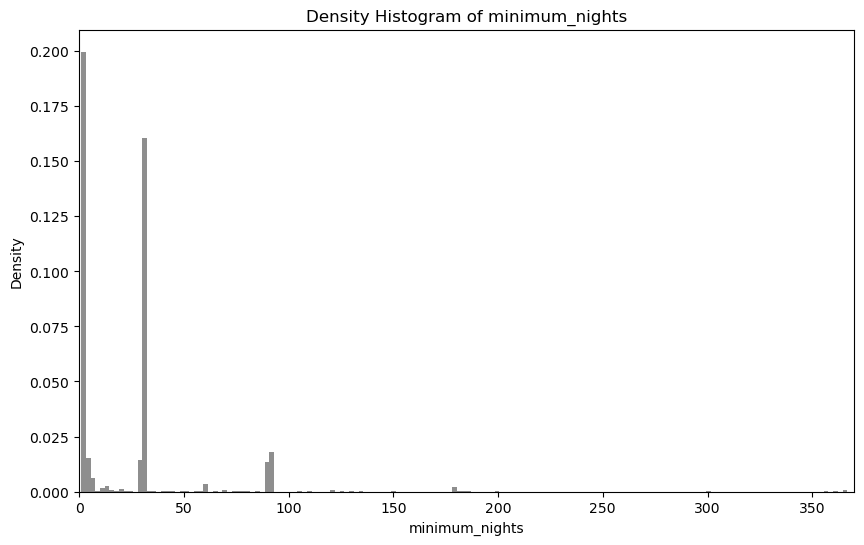

In [18]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(min_nt, color="DimGray", density=True, bins=501, alpha=0.75)
axes.set_xlabel("minimum_nights")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of minimum_nights")

axes.set_xlim(0, 370)

plt.show()
plt.close()

There are large clusters around 1 day and 31 days, with a smaller cluster around 90 and an even smaller cluster around 180. We look more closely at the most common values:

In [19]:
pd.DataFrame(min_nt.value_counts().sort_values(ascending=False)).head(20)

,minimum_nights
31,2796
1,1567
2,1566
3,733
91,349
32,314
90,254
30,231
4,190
5,104


There appear to be 3 main groups:

<ul>
    <li>Short-term rentals with minimum stays of a week or less</li>
    <li>Medium-term rentals with minimum stays around a month (28-31 days)</li>
    <li>Medium-term rentals with minimum stays around 3 months (90-91 days)</li>
</ul>

There are other minor clusters around 2 weeks, 2 months, and half a year.

We next print descriptive statistics for maximum nights.

In [20]:
pd.DataFrame(max_nt.describe())

,maximum_nights
count,"8,628.0000"
mean,"1,761.9905"
std,"107,652.1993"
min,1.0000
25%,120.0000
50%,365.0000
75%,"1,125.0000"
max,"9,999,999.0000"


These values are much higher, ranging from a minimum of 1 to a maximum of 9,999,999. The median is 365 days, much closer to the 25th percentile of 120 than the 75th percentile of 1125. The maximum stay is completely unreasonable (about 27,000 years), so we look more closely at the high end of the distribution to see how many are like that.

In [21]:
pd.DataFrame(max_nt.value_counts()).sort_index(ascending=False).head(15)

,maximum_nights
9999999,1
10000,1
3365,2
1825,1
1450,1
1125,3471
1124,29
1123,4
1120,4
1111,4


Only 6 values are above 1125, which appears to be the most common value with 3471 points. We display a histogram of values at or below 1125 days.

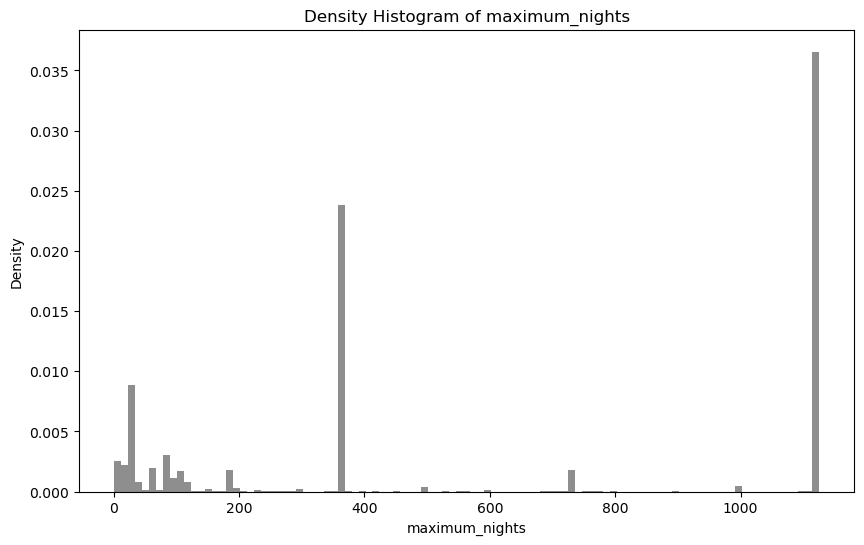

In [22]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(max_nt[max_nt < 1450], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("maximum_nights")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of maximum_nights")

plt.show()
plt.close()

There are three large clusters around 30, 365, and 1125 nights.

maximum_nights should increase with minimum_nights, so we display a scatterplot to investigate the relationship between them. We impose a maximum value of 1125 to make the plot readable.

In [23]:
max_nt[max_nt > 1125] = 1125

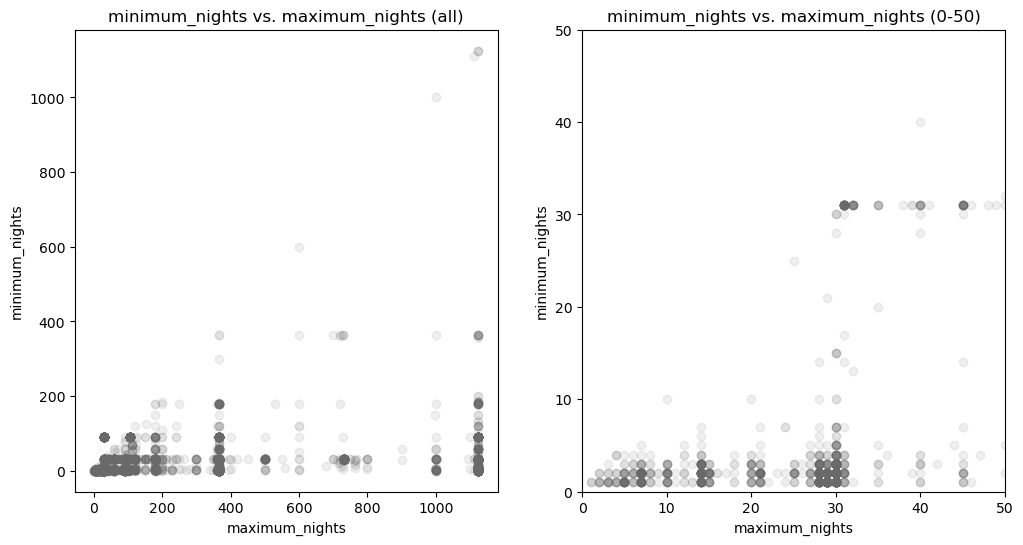

In [24]:
figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter(max_nt, min_nt, marker="o", color="dimgray", alpha=0.1)

axes.set_ylabel("minimum_nights")
axes.set_xlabel("maximum_nights")
axes.set_title("minimum_nights vs. maximum_nights (all)")

axes = figure.add_subplot(1, 2, 2)
axes.scatter(max_nt, min_nt, marker="o", color="dimgray", alpha=0.1)

axes.set_ylabel("minimum_nights")
axes.set_xlabel("maximum_nights")
axes.set_title("minimum_nights vs. maximum_nights (0-50)")
axes.set_ylim(0, 50)
axes.set_xlim(0, 50)

plt.show()
plt.close()

Many short-term rentals have very high maximum_nights around 1125. The zoomed-in view shows that ~30 days is the most common maximum_night cluster for short-term rentals.

The scatterplot does show some points that appear to have higher minimum_nights than maximum_nights, which shouldn't be possible.

In [25]:
vwListings.loc[min_nt > max_nt, ['minimum_nights', 'maximum_nights', 'host_id', 'number_of_reviews', 'price',
                          'has_availability', 'accommodates']].describe()

,minimum_nights,maximum_nights,host_id,number_of_reviews,price,has_availability,accommodates
count,90.0000,90.0000,90.0000,90.0000,90.0000,90.0000,90.0000
mean,91.0000,31.0000,"294,545,484.0000",0.0222,76.6222,1.0000,1.7333
std,0.0000,0.0000,0.0000,0.1482,22.1022,0.0000,0.4447
min,91.0000,31.0000,"294,545,484.0000",0.0000,34.0000,1.0000,1.0000
25%,91.0000,31.0000,"294,545,484.0000",0.0000,60.5000,1.0000,1.0000
50%,91.0000,31.0000,"294,545,484.0000",0.0000,72.5000,1.0000,2.0000
75%,91.0000,31.0000,"294,545,484.0000",0.0000,88.5000,1.0000,2.0000
max,91.0000,31.0000,"294,545,484.0000",1.0000,165.0000,1.0000,2.0000


There are 90 such listings, all with minimum_nights = 91 and maximum_nights = 31 from the same host with host_id = 294545484. Further, none of them have any reviews in the last 12 months (though a small number have some reviews from earlier), but all of them do have availability at prices that don't seem ridiculous.

In [26]:
pd.DataFrame(vwListings.loc[vwListings['host_id'] == 294545484, ['host_name', 'source_name', 'room_type']].value_counts())

0
host_name source_name      room_type           
June      listings_3_2023  Private room     163
          listings_12_2022 Private room     111
          listings_9_2022  Private room      24
          listings_12_2022 Entire home/apt   10
          listings_3_2023  Entire home/apt   10
          listings_9_2022  Entire home/apt    2

These listings are all from host_name "June" and are mostly private rooms.

### has_availability

In [27]:
ha = vwListings['has_availability']

has_availability keeps track of whether the listing has any availability in the calendar. It is potentially a way to spot "dead" listings that could be removed from the dataset. We print value counts.

In [28]:
pd.DataFrame(ha.value_counts())

,has_availability
1,8166
0,462


There are 8166 listings with availability and 462 listings with no availability. We take a closer look at the listings with no availability.

In [29]:
pd.DataFrame(vwListings.loc[ha == 0, 'minimum_nights'].value_counts(normalize=True)).head(15)

,minimum_nights
31,0.8831
70,0.0216
60,0.0152
90,0.0108
30,0.0108
180,0.0087
56,0.0087
365,0.0065
3,0.0043
1,0.0043


These listings are mostly medium- or long-term rentals, but not exclusively.

### first_review / last_review

In [30]:
fr = copy.copy(vwListings['first_review'])
lr = copy.copy(vwListings['last_review'])

In [31]:
vwListings[['first_review','last_review']].describe(datetime_is_numeric=True)

,first_review,last_review
count,6432,6432
mean,2019-11-01 16:32:54.626865664,2022-05-07 07:05:49.253731072
min,2009-01-20 00:00:00,2013-05-21 00:00:00
25%,2017-11-15 00:00:00,2022-05-16 00:00:00
50%,2020-06-12 00:00:00,2022-10-29 00:00:00
75%,2022-01-16 00:00:00,2023-02-28 06:00:00
max,2023-03-18 00:00:00,2023-03-18 00:00:00


There are 6432 first and last reviews out of 8628 total listings. This means that 2196 listings have no reviews. 

The earliest first_review is 1/20/2009 and the latest first_review is 3/18/2023 (the day before the data was most recently scraped). The earliest last_review is 5/21/2013 and the latest last_review is also 3/18/2023. A listing with their last review in 2013 is concerning, since they haven't gotten any reviews in nearly 10 years. This is another potential sign of a "dead" listing. I will look at a histogram of last_reviews.

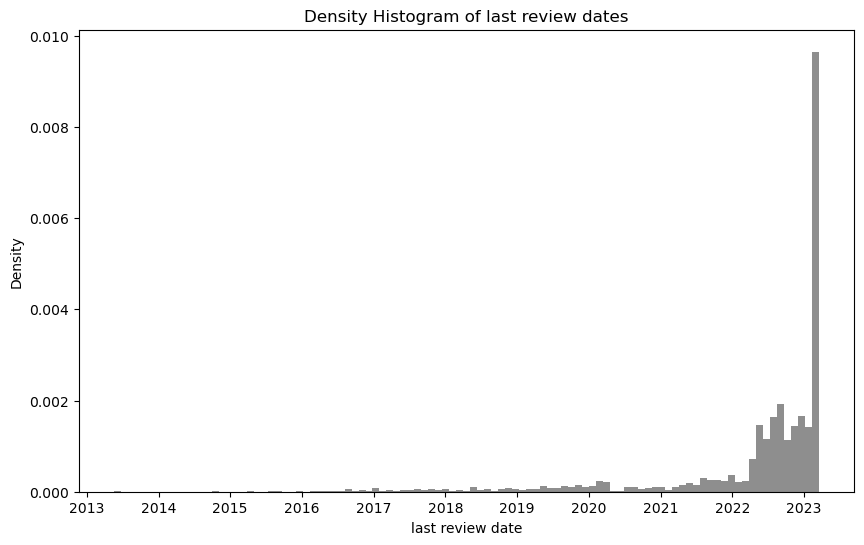

In [32]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(lr, color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("last review date")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of last review dates")

#axes.set_xlim(bins[0]-10, bins[75])
#axes.set_ylim(0, 0.001)

plt.show()
plt.close()

While most listings have a review within the past year, a surprisingly large number haven't had any reviews since 2019 or earlier. There is also a large gap in early 2020 during the beginning of the COVID pandemic, with a good number of listings having their last review in late 2019 or early 2020.

FIRST REVIEW HIST

### review_scores

There are 7 types of review scores left by guests. review_scores_rating is the overall rating of the experience. review_scores_accuracy rates how accurate the information provided by the host was. review_scores_cleanliness is self-explanatory, rating how clean the rental was. review_scores_checkin rates how easy the host made the check-in process. review_scores_communication rates how well the host communicated with the guests. review_scores_location is also self-explanatory, rating the location of the rental. Finally, review_scores_value rates how well the guest felt they got their money's worth.

We replace blank review values with NaN for now.

In [33]:
vwListings[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
     'review_scores_communication','review_scores_location','review_scores_value']] = vwListings[[
    'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
     'review_scores_communication','review_scores_location','review_scores_value']].replace('', np.NaN)

We display descriptive statistics for each review score.

In [34]:
vwListings[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin']].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin
count,"6,432.0000","6,407.0000","6,407.0000","6,407.0000"
mean,4.7042,4.7857,4.7361,4.8417
std,0.5097,0.3842,0.4088,0.3490
min,0.0000,1.0000,1.0000,1.0000
25%,4.6500,4.7500,4.6700,4.8400
50%,4.8400,4.9000,4.8700,4.9500
75%,4.9600,5.0000,4.9800,5.0000
max,5.0000,5.0000,5.0000,5.0000


In [35]:
vwListings[['review_scores_communication','review_scores_location','review_scores_value']].describe()

,review_scores_communication,review_scores_location,review_scores_value
count,"6,407.0000","6,407.0000","6,406.0000"
mean,4.8279,4.7636,4.6787
std,0.3718,0.3754,0.4265
min,1.0000,1.0000,1.0000
25%,4.8300,4.6900,4.6100
50%,4.9500,4.8900,4.7900
75%,5.0000,5.0000,4.9100
max,5.0000,5.0000,5.0000


There are 6432 review_scores_ratings (same as the number of listings with reviews), 6406 review_scores_values, and 6407 for the rest. Some listings have review_scores_ratings but not the other scores. 

review_scores_rating has a minimum value of 0 while the others don't have any scores below 1. The scores are out of 5, which is the maximum for each. review_scores_checkin has the highest mean of 4.84, closely followed by review_scores_communication at 4.83. review_scores_value has the lowest mean at 4.68. review_scores_rating has the next-lowest at 4.7, though this might be misleading since it has 25 more values.

In [36]:
vwListings.loc[~vwListings['review_scores_rating'].isna()&vwListings['review_scores_accuracy'].isna(), 'review_scores_rating'].mean()

0.0

The listings with review_scores_ratings but not the others all have ratings of 0. This helps explain why review_scores_rating has a relatively low mean, and also probably explains why it has the largest standard deviation.

We plot a histogram of review_scores_rating, probably the most important score.

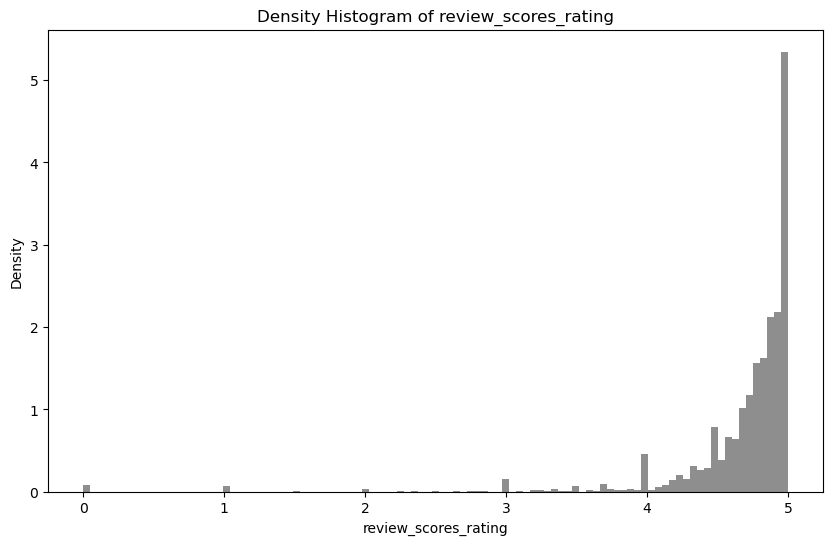

In [37]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(vwListings['review_scores_rating'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_rating")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of review_scores_rating")

plt.show()
plt.close()

A vast majority of scores are between 4 and 5, with most of those above 4.5. There are spikes at whole numbers, likely from listings with few reviews that average out there.

We also plot histograms for the other six scores to compare their distributions, seeing if any are notably different.

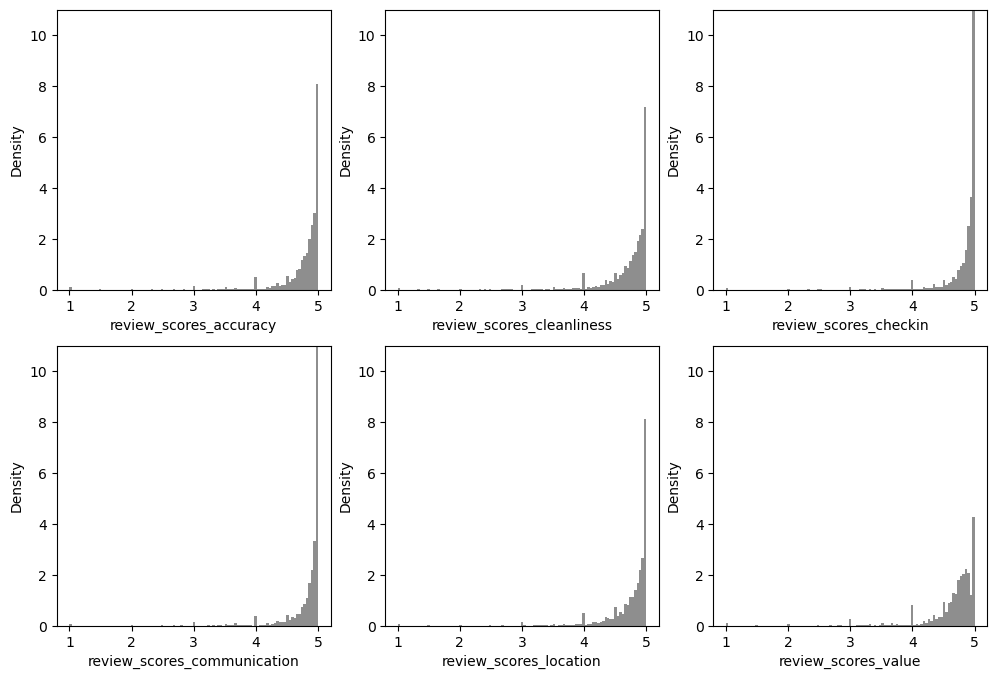

In [38]:
figure = plt.figure(figsize=(12,8))

axes = figure.add_subplot(2, 3, 1)
n, bins, patches = axes.hist(vwListings['review_scores_accuracy'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_accuracy")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 2)
n, bins, patches = axes.hist(vwListings['review_scores_cleanliness'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_cleanliness")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 3)
n, bins, patches = axes.hist(vwListings['review_scores_checkin'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_checkin")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 4)
n, bins, patches = axes.hist(vwListings['review_scores_communication'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_communication")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 5)
n, bins, patches = axes.hist(vwListings['review_scores_location'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_location")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 6)
n, bins, patches = axes.hist(vwListings['review_scores_value'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_value")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

plt.show()
plt.close()

review_scores_value has the most unique distribution. There are fewer perfect 5s and more 3s and 4s than the other review scores, and the values between 4 and 5 are less clustered near 5. review_scores_cleanliness exhibits those same characteristics to a lesser degree. review_scores_checkin and review_scores_communication are very closely clustered around 5.

### reviews_per_month

A blank value in reviews_per_month indicates no reviews, so we replace blanks with 0.

In [39]:
vwListings['reviews_per_month'] = vwListings['reviews_per_month'].replace('', 0)

In [40]:
rpm = vwListings['reviews_per_month']

We print descriptive statistics.

In [41]:
pd.DataFrame(rpm.describe())

,reviews_per_month
count,"8,628.0000"
mean,1.2866
std,1.9063
min,0.0000
25%,0.0000
50%,0.5100
75%,1.9700
max,59.6500


reviews_per_month ranges from 0 to 59.65, with a mean of 1.29 and a median of 0.51. It's unclear how a listing can get 59.65 reviews per month since that is more than 1 per day, so we look at the highest values.

In [42]:
pd.DataFrame(rpm.value_counts().sort_index(ascending=False)).head(10)

,reviews_per_month
59.6500,1
31.6700,1
24.5000,1
21.3400,1
21.3200,1
17.4900,1
16.2700,1
16.0100,1
14.8000,1
14.0300,1


There are two listings with more than one review per day, which shouldn't be possible. We look more closely at those listings:

In [99]:
vwListings.loc[rpm > 31, ['id','name','number_of_reviews_ltm','source_name','host_id']]

,id,name,number_of_reviews_ltm,source_name,host_id
4808,48425132,2 Queen Apt Suite | 2500 Penn Placemakr Experi...,561,listings_3_2023,389664429
7130,659366271388568374,Standard Queen Bed at Selina Union Market Wash...,517,listings_3_2023,459231442


The links to both of these listings appear dead. They should be dropped before modeling.

## Pairwise

If a listing has no availability, there are a few possibilities. It might simply be so popular that every available day for the upcoming year has been booked. It might be a dead listing that the host no longer makes available but hasn't removed from the site. Finally, it might be a brand-new listing that is still in the process of being set up by the host.

Listings that have no availability due to their popularity should clearly remain in the dataset, but the other two possibilities make good candidates to be dropped prior to modeling. To see which of these possibilities seem to hold, we look at has_availability against some other variables in the data.

### has_availability vs. last_review_dates

A popular listing should have recent reviews. Of the 462 no-availability listings, how many even have reviews? 

In [44]:
no_av = vwListings[ha == 0]

In [45]:
len(no_av[no_av['number_of_reviews'] > 0])

208

Only 208 have any reviews at all. To see if there are any popular no-availability listings, we display a histogram of last_review_dates for listings with no availability.

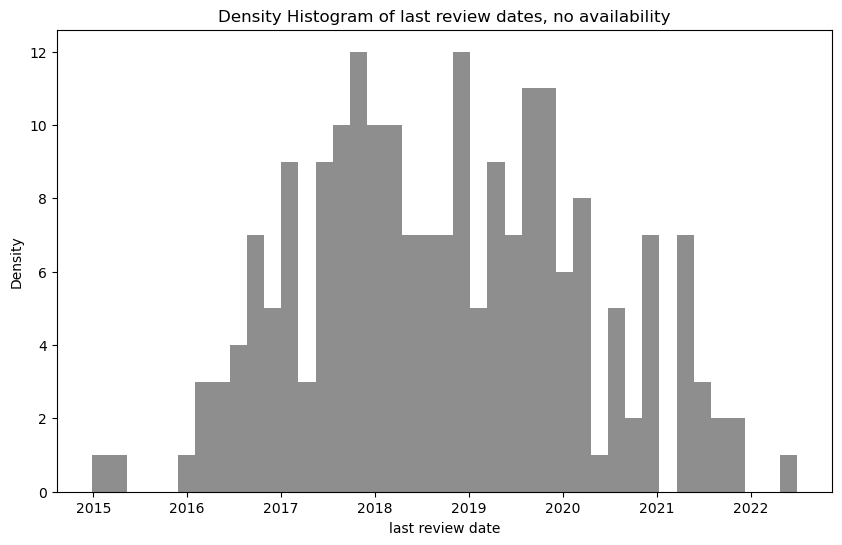

In [46]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(no_av['last_review'], color="DimGray", density=False, bins=41, alpha=0.75)
axes.set_xlabel("last review date")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of last review dates, no availability")

plt.show()
plt.close()

None of the no-availability listings got reviews in 2023, and only one of them got a review in 2022. Most got their last review before the COVID pandemic struck in early 2020. We conclude that none of these listings have no availability due to their popularity.

### has_availability vs. host_listings_count

254 of 462 no-availability listings have no reviews at all, which means they might be brand-new listings. Such listings seem much more likely to also have brand-new hosts, especially if it's the host's only listing. We look at host_listings_count for no-review, no-availability listings.

In [47]:
no_r_no_av = no_av[no_av['number_of_reviews']==0]

In [48]:
pd.DataFrame(no_r_no_av['host_listings_count'].value_counts())

,host_listings_count
1,195
2,30
15,15
3,9
4,2
8,2
5,1


Of the 254 no-review, no-availability listings, 195 are a host's only listing and 30 are one of the host's two listings. 15 are all from the same host.

### has_availability vs. host_since

Most no-review, no-availability listings are their host's only listing. If these are brand-new listings, their hosts likely joined the site recently too. To investigate, we display a histogram of host_since for no-review, no-availability listings.

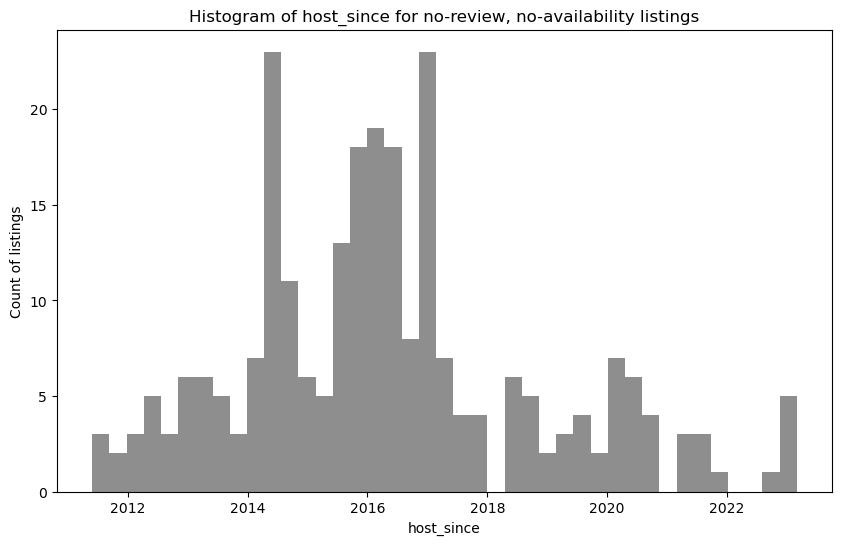

In [49]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(no_r_no_av['host_since'], color="DimGray", 
                             density=False, bins=41, alpha=0.75)
axes.set_xlabel("host_since")
axes.set_ylabel("Count of listings")
axes.set_title("Histogram of host_since for no-review, no-availability listings")

plt.show()
plt.close()

Only six of these listings have hosts who joined relatively recently (2022 or later). We take a closer look at these listings.

In [50]:
no_r_no_av.loc[no_r_no_av['host_since'] > pd.to_datetime('2022-01-01'),
         ['MAX(last_scraped)','host_id','host_since','host_total_listings_count']]

,MAX(last_scraped),host_id,host_since,host_total_listings_count
7853,2022-12-20,488242955,2022-11-18,1
8429,2023-03-19,501998814,2023-02-20,2
8430,2023-03-19,501428596,2023-02-16,2
8454,2023-03-19,502923600,2023-02-26,1
8476,2023-03-19,503691862,2023-03-03,1
8589,2023-03-19,501998814,2023-02-20,2


host_id = 488242955 had their listing on the site for a very short period of time. The other 5 seem like brand-new listings that their hosts have not finished setting up. 

NOTE TO GROUP 9: Most no-availability listings seem to be dead listings except for possibly the 5 brand-new ones. I recommend we drop all of them (<i>maybe</i> keeping the brand-new ones in).

In [51]:
vwListings1 = vwListings[ha == 1]

### property_type vs. room_type

Earlier we noticed more listings with property_type = 'Room in hotel' than room_type = 'Hotel room'. We look more closely at listings whose property_type begins with 'room':

In [52]:
pd.DataFrame(vwListings.loc[vwListings['property_type'].str.split().str.get(0) == 'Room', ['room_type', 'property_type']].value_counts())

0
room_type       property_type                  
Private room    Room in boutique hotel      117
                Room in hotel                98
Entire home/apt Room in aparthotel           19
Hotel room      Room in hostel               11
                Room in bed and breakfast     6
                Room in boutique hotel        3
                Room in serviced apartment    2

There are 117 Rooms in boutiqe hotels and 98 Rooms in hotels with room_type = 'Private room' instead of 'Hotel room'.

In [53]:
pd.DataFrame(vwListings.loc[vwListings['room_type'] == 'Hotel room', 'property_type'].value_counts())

,property_type
Room in hostel,11
Room in bed and breakfast,6
Room in boutique hotel,3
Room in serviced apartment,2


In addition to 'Room in boutique hotel' and 'Room in hotel', 'Private room in bed and breakfast' is another property_type that isn't listed as a hotel room but should be. More evidence for this can be found by comparing property_type with price.

### property_type vs. price

We look at descriptive statistics for the top 20 property types by count.

In [54]:
vwListings.groupby('property_type')['price'].describe().sort_values('count', ascending=False).head(20).sort_index()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Entire condo,673.0000,152.5542,100.7482,39.0000,95.0000,129.0000,176.0000,"1,425.0000"
Entire guest suite,552.0000,114.2120,49.4393,41.0000,85.0000,101.0000,130.0000,400.0000
Entire guesthouse,79.0000,200.4810,198.7484,66.0000,111.5000,130.0000,182.5000,"1,237.0000"
Entire home,935.0000,329.6128,492.1706,10.0000,140.0000,220.0000,350.0000,"7,500.0000"
Entire loft,37.0000,196.6757,202.6336,64.0000,99.0000,144.0000,200.0000,"1,250.0000"
Entire rental unit,"2,819.0000",165.4317,125.5704,32.0000,100.0000,138.0000,191.0000,"3,000.0000"
Entire serviced apartment,655.0000,224.9985,97.7207,56.0000,159.5000,212.0000,279.0000,716.0000
Entire townhouse,630.0000,280.5524,265.5580,45.0000,149.0000,215.0000,329.5000,"4,357.0000"
Private room in bed and breakfast,45.0000,248.4222,188.5111,43.0000,88.0000,178.0000,350.0000,799.0000


Unsurprisingly, shared rooms have the lowest mean price. "Entire" listings also generally have higher mean price than private rooms, which are generally low. Somewhat surprisingly, rooms in hotels (including private rooms in bed and breakfasts) have some of the highest prices. This gives us more evidence that 'Room in hotel', 'Room in boutique hotel', and 'Private room in bed and breakfast' should be grouped together with hotel rooms instead of with private rooms. 

We create a new feature room_type_mod that implements this change.

In [55]:
vwListings['room_type_mod'] = vwListings['room_type']
vwListings.loc[vwListings['property_type'].isin(['Room in hotel', 'Room in boutique hotel', 'Private room in bed and breakfast']),
        'room_type_mod'] = 'Hotel room'

### room_type vs. price

We look at descriptive statistics for room_type and room_type_mod.

In [56]:
vwListings.groupby('room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,"6,455.0000",202.1960,238.3444,10.0000,105.0000,150.0000,228.0000,"7,500.0000"
Hotel room,22.0000,59.9545,106.8860,0.0000,25.0000,27.0000,29.0000,489.0000
Private room,"2,028.0000",123.7771,167.2375,20.0000,52.0000,75.0000,114.0000,"2,000.0000"
Shared room,123.0000,54.0244,25.0882,16.0000,35.0000,45.0000,63.5000,140.0000


In [57]:
vwListings.groupby('room_type_mod')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type_mod,,,,,,,,
Entire home/apt,"6,455.0000",202.1960,238.3444,10.0000,105.0000,150.0000,228.0000,"7,500.0000"
Hotel room,282.0000,334.6099,286.8234,0.0000,139.0000,264.5000,432.0000,"1,903.0000"
Private room,"1,768.0000",89.3546,104.4410,20.0000,50.0000,68.0000,95.0000,"2,000.0000"
Shared room,123.0000,54.0244,25.0882,16.0000,35.0000,45.0000,63.5000,140.0000


The changes of the previous section greatly increase the Hotel room mean price, making it the highest at 335. They also greatly decrease the Private room mean price, making it the second-lowest at 89. Entire home/apt has the second-highest mean of 202 and Shared room has the lowest mean of 54. 

For each room_type, the median is lower than the mean and closer to the 25th percentile than the 75th percentile. This indicates right-tailed distributions, which we verify by displaying price histograms for each room_type_mod.

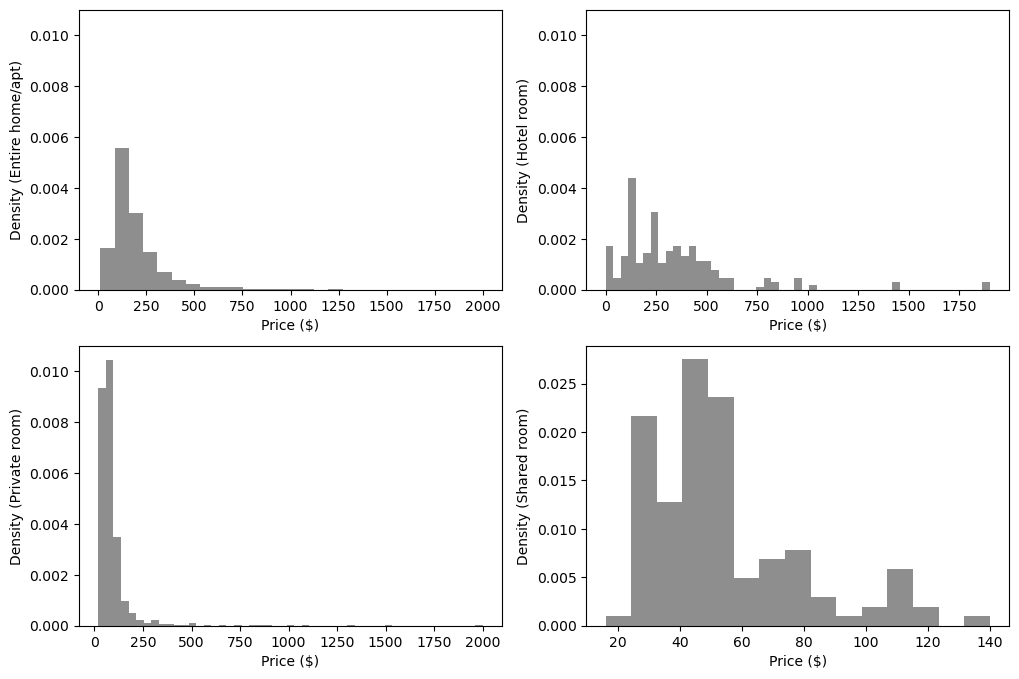

In [69]:
figure = plt.figure(figsize=(12,8))

axes = figure.add_subplot(2, 2, 1)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Entire home/apt', 'price'], 
                             color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Entire home/apt)")
axes.set_ylim(0, 0.011)
axes.set_xlim(-100, 2100)

axes = figure.add_subplot(2, 2, 2)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Hotel room','price'], 
                             color="DimGray", density=True, bins=51, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Hotel room)")
axes.set_ylim(0, 0.011)

axes = figure.add_subplot(2, 2, 3)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Private room', 'price'],
                             color="DimGray", density=True, bins=51, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Private room)")
axes.set_ylim(0, 0.011)

axes = figure.add_subplot(2, 2, 4)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Shared room','price'], 
                             color="DimGray", density=True, bins=15, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Shared room)")

plt.show()
plt.close()

Each room type has a right-skewed distribution, though the skew is more pronounced for 'Entire home/apt' and 'Private room'. 

### minimum_nights vs. price

We display a scatterplot of price vs. minimum nights, expecting the highest prices to be for short-term rentals.

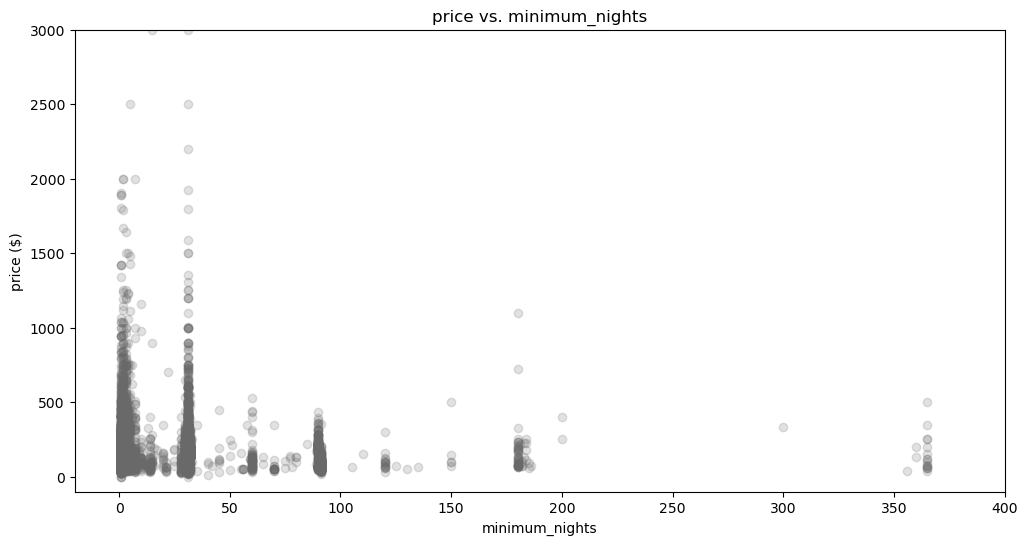

In [60]:
figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(min_nt, vwListings['price'], marker="o", color="dimgray", alpha=0.2)

axes.set_ylabel("price ($)")
axes.set_xlabel("minimum_nights")
axes.set_title("price vs. minimum_nights")

axes.set_xlim(-20, 400)
axes.set_ylim(-100, 3000)

plt.show()
plt.close()

As expected, the highest prices are generally in short-term rentals. There seems to be a negative relationship here. We calculate correlation coefficients to verify this.

In [59]:
print("r   = ", stats.pearsonr(vwListings['minimum_nights'], vwListings['price'])[0])
print("rho = ", stats.spearmanr(vwListings['minimum_nights'], vwListings['price'])[0])

r   =  -0.04816124396500879
rho =  -0.13622089555769695


Pearson's coefficient is only slightly negative at -0.048, indicating a weak negative relationship. Spearman's coefficient is lower at -0.136, indicating some non-linearity in the relationship.

### first_review / last_review vs. price

We display a scatterplot of first_review against price.

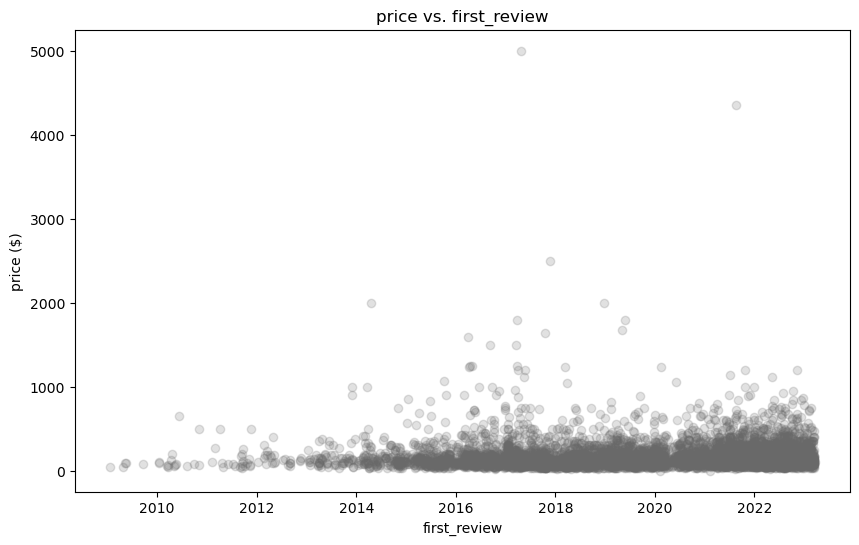

In [78]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings['first_review'], vwListings['price'], marker="o", color="dimgray", alpha=0.2)

axes.set_ylabel("price ($)")
axes.set_xlabel("first_review")
axes.set_title("price vs. first_review")

plt.show()
plt.close()

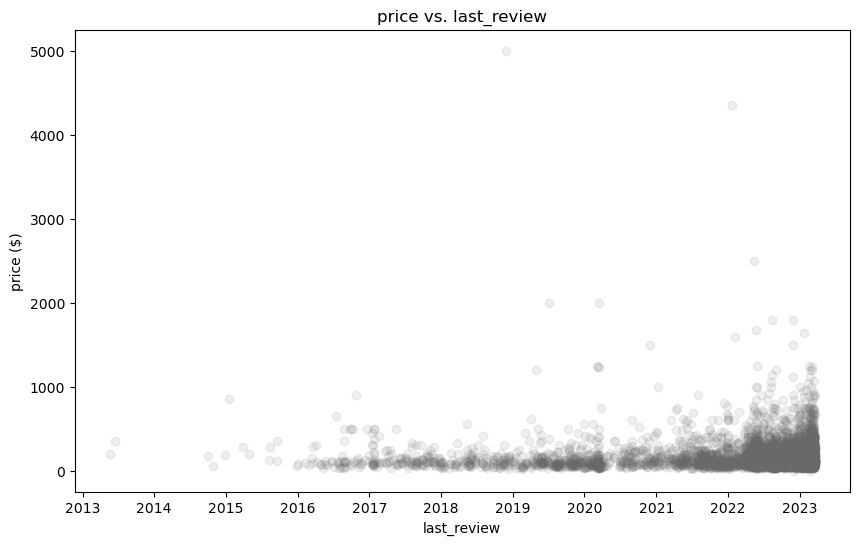

In [79]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings['last_review'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)

axes.set_ylabel("price ($)")
axes.set_xlabel("last_review")
axes.set_title("price vs. last_review")

plt.show()
plt.close()

### review_scores vs. price

We display a scatterplot of price against the main score, review_scores_rating.

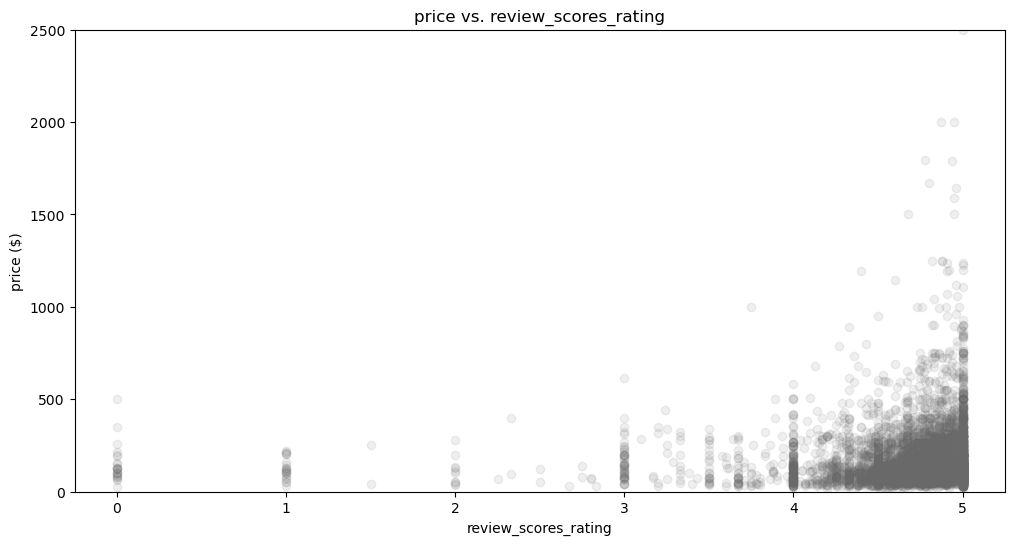

In [63]:
figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings['review_scores_rating'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)
axes.set_ylabel("price ($)")
axes.set_xlabel("review_scores_rating")
axes.set_title("price vs. review_scores_rating")

axes.set_ylim(0, 2500)

plt.show()
plt.close()

There appears to be a slightly positive relationship with some curvature. We calculate correlation coefficients to confirm this.

In [72]:
vwListings_temp = vwListings[~vwListings['review_scores_rating'].isna()]

In [73]:
print("r   = ", stats.pearsonr(vwListings_temp['review_scores_rating'], vwListings_temp['price'])[0])
print("rho = ", stats.spearmanr(vwListings_temp['review_scores_rating'], vwListings_temp['price'])[0])

r   =  0.054585987814064305
rho =  0.09913275980985725


Pearson's coefficient of 0.055 indicates a very slight positive relationship between price and review_scores_rating. Spearman's coefficient is a bit higher at 0.099, indicating some non-linearity in the relationship.

We also display scatterplots of the other review_scores against price.

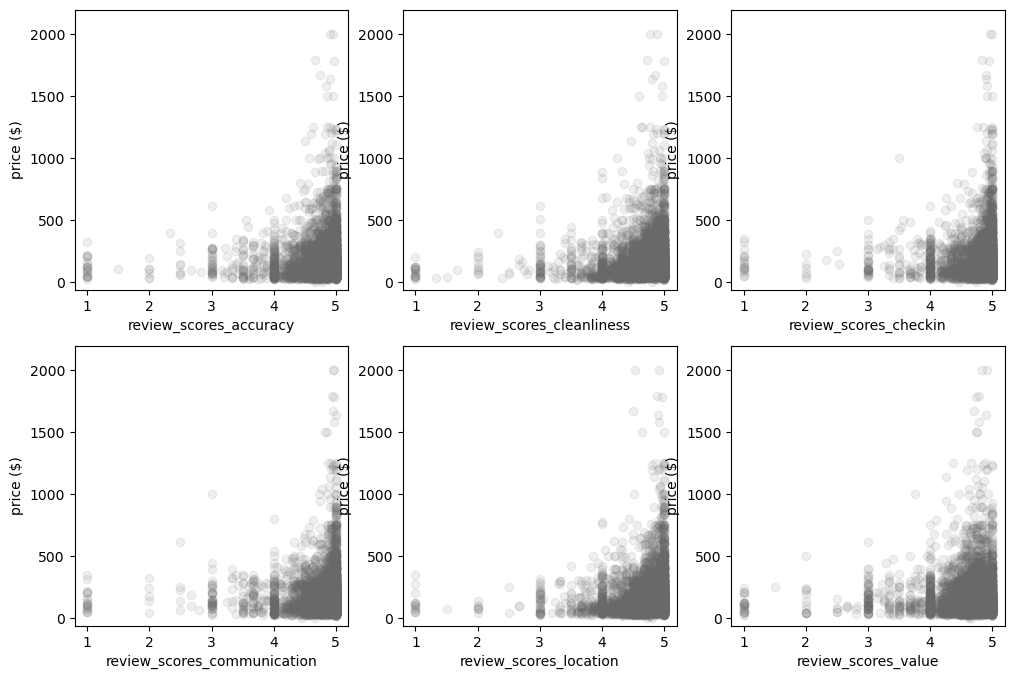

In [64]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(2, 3, 1)
axes.scatter(vwListings['review_scores_accuracy'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)
axes.set_ylabel("price ($)")
axes.set_xlabel("review_scores_accuracy")
axes.set_ylim(-60, 2200)

axes = figure.add_subplot(2, 3, 2)
axes.scatter(vwListings['review_scores_cleanliness'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)
axes.set_ylabel("price ($)")
axes.set_xlabel("review_scores_cleanliness")
axes.set_ylim(-60, 2200)

axes = figure.add_subplot(2, 3, 3)
axes.scatter(vwListings['review_scores_checkin'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)
axes.set_ylabel("price ($)")
axes.set_xlabel("review_scores_checkin")
axes.set_ylim(-60, 2200)

axes = figure.add_subplot(2, 3, 4)
axes.scatter(vwListings['review_scores_communication'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)
axes.set_ylabel("price ($)")
axes.set_xlabel("review_scores_communication")
axes.set_ylim(-60, 2200)

axes = figure.add_subplot(2, 3, 5)
axes.scatter(vwListings['review_scores_location'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)
axes.set_ylabel("price ($)")
axes.set_xlabel("review_scores_location")
axes.set_ylim(-60, 2200)

axes = figure.add_subplot(2, 3, 6)
axes.scatter(vwListings['review_scores_value'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)
axes.set_ylabel("price ($)")
axes.set_xlabel("review_scores_value")
axes.set_ylim(-60, 2200)

plt.show()
plt.close()

The relationships between these scores and price seem very similar. review_scores_value seems like the most interesting of these scores, so we calculate correlation coefficients between this variable and price.

In [76]:
vwListings_temp = vwListings[~vwListings['review_scores_value'].isna()]

In [75]:
print("r   = ", stats.pearsonr(vwListings_temp['review_scores_value'], vwListings_temp['price'])[0])
print("rho = ", stats.spearmanr(vwListings_temp['review_scores_value'], vwListings_temp['price'])[0])

r   =  0.016801024020832177
rho =  -0.002890217924933811


Both Pearson's and Spearman's coefficients are nearly zero, indicating no relationship between review_score_value and price. While pricier listings seem to get slightly higher overall scores, it also seems that reviewers tend to penalize pricier places when giving a value score.

### reviews_per_month vs. price

We display a scatterplot of reviews_per_month against price.

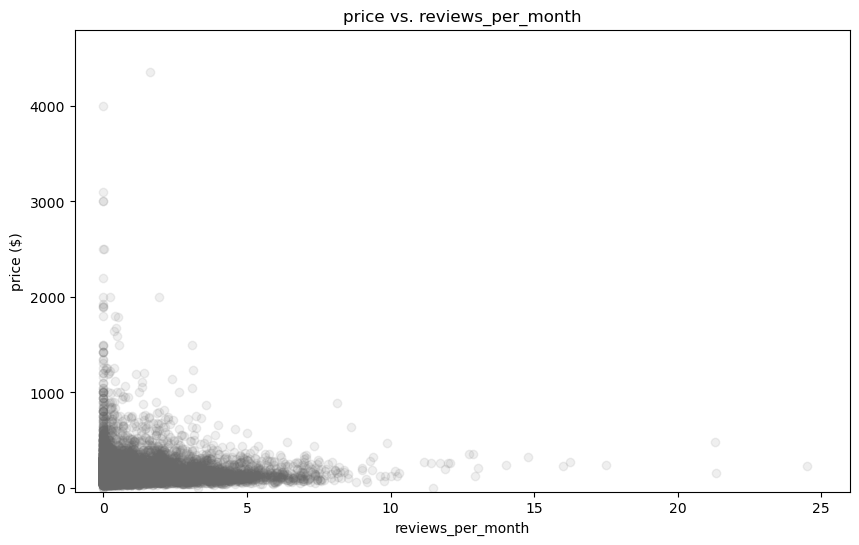

In [77]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings['reviews_per_month'], vwListings['price'], marker="o", color="dimgray", alpha=0.1)

axes.set_ylabel("price ($)")
axes.set_xlabel("reviews_per_month")
axes.set_title("price vs. reviews_per_month")

axes.set_xlim(-1, 26)
axes.set_ylim(-40, 4800)

plt.show()
plt.close()

Since reviews_per_month are so clustered near 0, it's difficult to tell whether there's a relationship here. We look to correlation coefficients for more information.

In [96]:
print("r   = ", stats.pearsonr(vwListings['reviews_per_month'], vwListings['price'])[0])
print("rho = ", stats.spearmanr(vwListings['reviews_per_month'], vwListings['price'])[0])

r   =  -0.03157576340933626
rho =  -0.007065132372914153


Both coefficients are near zero, indicating no relationship between price and reviews_per_month.